In [167]:
import pandas as pd
import numpy as np
from numpy import trapz
import math
from scipy.stats import norm
from sklearn.feature_selection import f_regression
import statsmodels.api as sm
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [26]:
with open('inds_to_name.pkl','r') as pickleFile:
    inds_to_name = pickle.load(pickleFile)

In [80]:
# cats = ['tee3','tee45','green0','green5','green10','green20','rough0','rough90',
#         'rough375','fairway0','fairway300','fairway540','bunker','other']
cats = ['putting','tee','approach','around_green']

In [81]:
ranks,reps = {},{}
for cat in cats:
    ranks[cat] = np.load('ranksb-13-0.95-12/%s_ranks.npy' % cat)
    reps[cat] = np.load('ranksb-13-0.95-12/%s_reps.npy' % cat)

In [101]:
ranks['putting'].shape

(1992, 136)

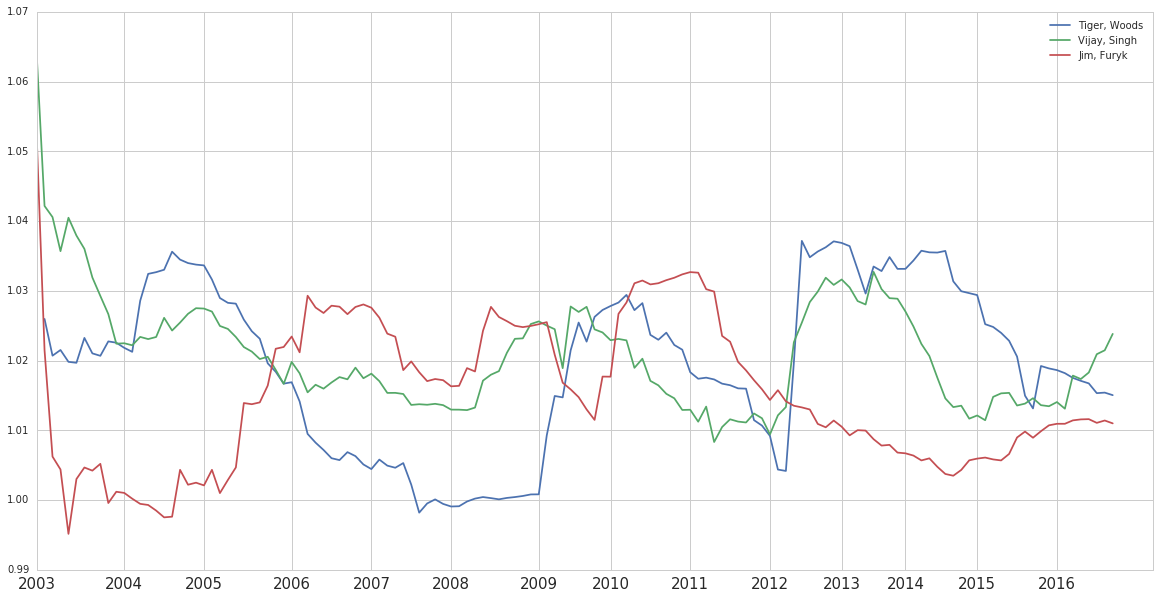

In [92]:
names_to_ind = {value:key for key,value in inds_to_name.iteritems()}
# inds_to_plot = [names_to_ind['Vijay, Singh'],names_to_ind['Tiger, Woods'],names_to_ind['Luke, Donald'],
#                 names_to_ind['Phil, Mickelson'],names_to_ind['Steve, Stricker'],names_to_ind['Jim, Furyk']]
inds_to_plot = [names_to_ind['Tiger, Woods'],names_to_ind['Vijay, Singh'],names_to_ind['Jim, Furyk']]#,
                #names_to_ind['Dustin, Johnson'],names_to_ind['Steve, Stricker'],
                #names_to_ind['Jordan, Spieth'], names_to_ind['Jason, Day']]
fig, ax = plt.subplots(figsize=(20, 10))
for j in inds_to_plot:
    #area = trapz(y[np.logical_not(np.isnan(y))], dx=5)
    y = [ranks['around_green'][j,i] for i in range(ranks['putting'].shape[1])]
    plt.plot(y,label = inds_to_name[j]);
ax.xaxis.set_ticks([i[1] for i in year_inds])
labels = [i[0] for i in year_inds]
ax.set_xticklabels(labels,fontsize=15);
plt.legend();

In [93]:
with open('hole_tups.pkl','r') as pickleFile:
    hole_tups = pickle.load(pickleFile)

In [94]:
bin_size = 4
window_size = 28
# n_tournament_groups = int(math.ceil(n_tournaments/float(bin_size)))
current_group = 0
tournament_groups = defaultdict(set)
tournaments = set()
group_to_tups = {}
holes_to_inflate = []
for tup in hole_tups:
    tournaments.add(tuple(tup[0:2]))
    tournament_group = (len(tournaments)-1)/bin_size
    if tournament_group>current_group:
        current_group = tournament_group
        group_to_tups[current_group] = holes_to_inflate
        holes_to_inflate = []
    tournament_groups[current_group+1].add(tuple(tup[0:2]))
    holes_to_inflate.append(tuple(tup))

In [95]:
year_inds = [max([[i[0] for i in tournament_groups[j]]]) for j in tournament_groups]
from collections import Counter
year_inds = [Counter(i) for i in year_inds]
year_inds = [sorted(i,key=year_inds[u].get,reverse=True)[0] for u,i in enumerate(year_inds)]
year_inds = np.array(year_inds)
year_inds = [(year,np.argwhere(year_inds==year).min()) for year in range(2003,2017)]

In [96]:
with open('num_to_ind.pkl','r') as pickleFile:
    num_to_ind = pickle.load(pickleFile)

In [114]:
data = pd.read_csv('data/round.csv')
data.insert(5,'Player_Index',[num_to_ind[num] if num in num_to_ind else np.nan for num in data.Player_Number])
rounds = data.groupby(['Tournament_Year','Permanent_Tournament_#','Round_Number','Course_#'])
n_players = len(num_to_ind)

In [120]:
d = {'Player_Index':[],'Permanent_Tournament_#':[],'Course_#':[],'Finishing_Pct':[]}
d.update({'Field_Strength_%s' % cat:[] for cat in cats})
d.update({'Rating_%s' % cat:[] for cat in cats})
d.update({'Reps_%s' % cat:[] for cat in cats})
d.update({'Pct_Reps_%s' % cat:[] for cat in cats})
master_df = pd.DataFrame(d)
for j in range(ranks['putting'].shape[1]):
    d = {'rank_%s' % cat: ranks[cat][:,j] for cat in cats}
    d.update({'reps_%s' % cat: reps[cat][:,j] for cat in cats})
    df = pd.DataFrame(d).dropna()
    pct_reps,rank_dict,reps_dict,pct_reps_dict = {},{},{},{}
    for cat in cats:
        pct_reps[cat] = pd.Series(df['reps_%s' % cat][df['reps_%s' % cat]!=0]).rank(pct=True)
        df.insert(len(df.columns),'pct_reps_%s' % cat,[0]*len(df))
        df.ix[df['reps_%s' % cat]!=0,'pct_reps_%s' % cat] = pct_reps[cat]
        rank_dict[cat] = df['rank_%s' % cat].to_dict()
        reps_dict[cat] = df['reps_%s' % cat].to_dict()
        pct_reps_dict[cat] = df['pct_reps_%s' % cat].to_dict()
    years = [i[0] for i in tournament_groups[j+2]]
    t_ids = [i[1] for i in tournament_groups[j+2]]
    df2 = data[data['Tournament_Year'].isin(years) & data['Permanent_Tournament_#'].isin(t_ids)]
    grouped = df2.groupby(['Player_Index','Permanent_Tournament_#','Course_#','Tournament_Year'],as_index=False)
    df3 = grouped['Finishing_Pct'].mean()
    for cat in cats:
        df3['Rating_%s' % cat] = df3['Player_Index'].map(rank_dict[cat])
        df3['Reps_%s' % cat] = df3['Player_Index'].map(reps_dict[cat])
        df3['Pct_Reps_%s' % cat] = df3['Player_Index'].map(pct_reps_dict[cat])
    df3 = df3[np.array([df3['Rating_%s' % cat]!=0 for cat in cats]).T.sum(1)==len(cats)].dropna()
    tourn_strength_dict = {}
    for cat in cats:
        tourn_strength_dict[cat] = df3.groupby('Permanent_Tournament_#')['Rating_%s' % cat].mean().to_dict()
        df3['Field_Strength_%s' % cat] = df3['Permanent_Tournament_#'].map(tourn_strength_dict[cat])
    master_df = pd.concat([master_df,df3])

In [121]:
master_df.shape

(85094, 21)

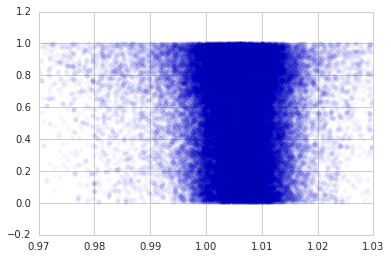

In [122]:
plt.scatter(master_df['Rating_%s' % ('putting',)],master_df.Finishing_Pct,alpha=.04);
plt.xlim(.97,1.03);

In [123]:
np.corrcoef(master_df['Rating_%s' % ('putting',)],master_df.Finishing_Pct)

array([[ 1.        , -0.05459968],
       [-0.05459968,  1.        ]])

In [124]:
np.corrcoef(master_df['Rating_%s' % ('putting',)]-master_df['Field_Strength_%s' % ('putting',)],master_df.Finishing_Pct)

array([[ 1.        , -0.05382738],
       [-0.05382738,  1.        ]])

In [125]:
for cat in cats:
    print cat,np.corrcoef(master_df['Rating_%s' % cat],master_df.Finishing_Pct)[0,1]

putting -0.05459968447
tee -0.176500015487
approach -0.170242041674
around_green -0.0695185952014


In [127]:
#X_lab = np.array(cats)[np.argsort([np.corrcoef(master_df['Rating_%s' % cat],master_df.Finishing_Pct)[0,1] for cat in cats])]
X = master_df[['Rating_%s' % (cat,) for cat in cats]].values - master_df[['Field_Strength_%s' % (cat,) for cat in cats]].values

In [129]:
y = master_df.Finishing_Pct

In [130]:
F,pval = f_regression(X,y)

In [131]:
F

array([  247.26083185,  2739.16184964,  2752.86930039,   393.35095585])

In [132]:
pval

array([  1.23056137e-55,   0.00000000e+00,   0.00000000e+00,
         2.43329153e-87])

In [133]:
np.argsort(pval)

array([1, 2, 3, 0])

In [134]:
np.array(cats)[np.argsort(pval)]

array(['tee', 'approach', 'around_green', 'putting'], 
      dtype='|S12')

In [254]:
X = master_df[['Rating_%s' % (cat,) for cat in cats]].values - master_df[['Field_Strength_%s' % (cat,) for cat in cats]].values
X = sm.add_constant(X)
X = np.hstack((X,master_df[['Reps_%s' % cat for cat in cats]].values.mean(1)[:,None]))
X = pd.DataFrame(X)
X.columns = ['coef']+cats+['reps']
y = master_df.Finishing_Pct.reset_index(drop=True)
X = X.reset_index(drop=True)
model = sm.GLM(y, X, family=sm.families.Binomial())
results = model.fit()

In [255]:
print results.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Finishing_Pct   No. Observations:                85094
Model:                            GLM   Df Residuals:                    85088
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -57248.
Date:                Tue, 20 Sep 2016   Deviance:                   1.4349e+05
Time:                        23:06:05   Pearson chi2:                 2.89e+04
No. Iterations:                    56                                         
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
coef             0.4093      0.015     26.552      0.000         0.379     0.440
putting         -8.7084      0.892     -9.758 

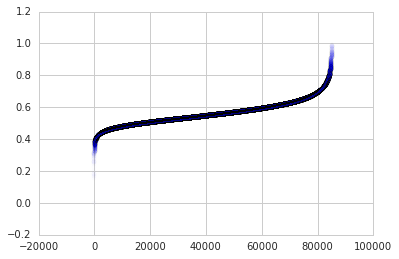

In [256]:
plt.scatter(range(len(master_df)),np.sort(results.predict(X)),alpha=.01);

In [257]:
np.mean(results.resid_pearson**2)

0.3399357151150246

In [258]:
np.corrcoef(results.resid_pearson**2,master_df[['Pct_Reps_%s' % (cat,) for cat in cats]].values.mean(1))

array([[ 1.        , -0.00729615],
       [-0.00729615,  1.        ]])

In [146]:
master_df.insert(len(master_df.columns),'Predicted_Finishing_Pct',results.predict(X))
# master_df.insert(len(master_df.columns),'Var_of_Pred_Finishing_Pct',1/w)
master_df.insert(len(master_df.columns),'Player_Name',[inds_to_name[ind] for ind in master_df.Player_Index])
master_df = master_df.reset_index()

In [150]:
master_df.sort_values('Predicted_Finishing_Pct',ascending=True)[['Player_Name','Player_Index','Predicted_Finishing_Pct',
                                                                 'Finishing_Pct','Tournament_Year','Course_#']].head(10)

,Player_Name,Player_Index,Predicted_Finishing_Pct,Finishing_Pct,Tournament_Year,Course_#
83720,"Franklin, Corpening",1660,0.001497,0.880263,2016,21
35754,"Richard, Sterne",1130,0.155253,0.263089,2008,9
537,"Bob, Estes",155,0.168088,0.279867,2003,4
538,"Bob, Estes",155,0.168088,0.279867,2003,104
114,"Ian, Leggatt",31,0.181290,0.894912,2003,4
115,"Ian, Leggatt",31,0.181290,0.894912,2003,104
539,"Bob, Estes",155,0.183886,0.116898,2003,500
116,"Ian, Leggatt",31,0.198034,0.774306,2003,500
79152,"Richie, Ramsay",1148,0.225525,0.741342,2015,706
78347,"Andy, Sullivan",1816,0.243687,0.148684,2015,23


Broadie aves

In [19]:
broadie_cats = ['Putting','Off-the-Tee','Approach-the-Green','Around-the-Green']

In [159]:
broadie_aves,broadie_opps = {},{}
for cat in broadie_cats:
    broadie_aves[cat] = np.load('Broadie_aves/%s_ave.npy' % cat)
    broadie_opps[cat] = np.load('Broadie_aves/%s_count.npy' % cat)

(-0.015, 0.025)

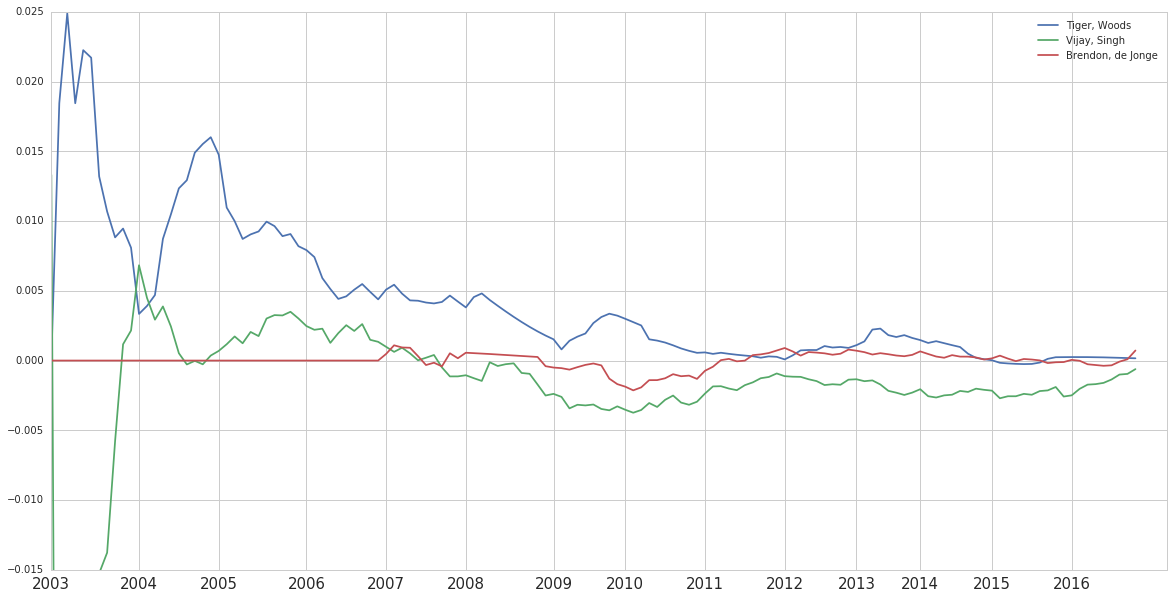

In [192]:
names_to_ind = {value:key for key,value in inds_to_name.iteritems()}
# inds_to_plot = [names_to_ind['Vijay, Singh'],names_to_ind['Tiger, Woods'],names_to_ind['Luke, Donald'],
#                 names_to_ind['Phil, Mickelson'],names_to_ind['Steve, Stricker'],names_to_ind['Jim, Furyk']]
inds_to_plot = [names_to_ind['Tiger, Woods'],names_to_ind['Vijay, Singh'],1087]#,
                #names_to_ind['Dustin, Johnson'],names_to_ind['Steve, Stricker'],
                #names_to_ind['Jordan, Spieth'], names_to_ind['Jason, Day']]
fig, ax = plt.subplots(figsize=(20, 10))
for j in inds_to_plot:
    #area = trapz(y[np.logical_not(np.isnan(y))], dx=5)
    y = [ra[i][j] for i in range(broadie_aves['Putting'].shape[1])]
    plt.plot(y,label = inds_to_name[j]);
ax.xaxis.set_ticks([i[1] for i in year_inds])
labels = [i[0] for i in year_inds]
ax.set_xticklabels(labels,fontsize=15);
plt.legend();
plt.ylim(-.015,.025)

In [168]:
def my_norm(x,BETA):
    return norm.pdf(x,0,BETA)/norm.pdf(0,0,BETA)

In [176]:
def take_weighted_ave(A,beta):
    M = np.array([[my_norm(j,beta)]*A.shape[0] for j in range(A.shape[1])[::-1]]).T
    return np.multiply(M,A).mean(1)

In [202]:
beta = 9
d = {'Player_Index':[],'Permanent_Tournament_#':[],'Course_#':[],'Finishing_Pct':[]}
d.update({'Field_Strength_%s' % cat:[] for cat in broadie_cats})
d.update({'Rating_%s' % cat:[] for cat in broadie_cats})
d.update({'Reps_%s' % cat:[] for cat in broadie_cats})
d.update({'Pct_Reps_%s' % cat:[] for cat in broadie_cats})
master_df_broadie = pd.DataFrame(d)
broadie_ranks,broadie_reps = {},{}
ra,re = [],[]
for j in range(broadie_aves['Putting'].shape[1]):
    for cat in broadie_cats:
        if cat not in broadie_ranks:
            broadie_ranks[cat],broadie_reps[cat] = None,None
        broadie_ranks[cat] = take_weighted_ave(broadie_aves[cat][:,:j+1],beta)
        broadie_reps[cat] = take_weighted_ave(broadie_opps[cat][:,:j+1],beta)
        if cat=='Putting':
            ra.append(broadie_ranks[cat])
            re.append(broadie_reps[cat])
    d = {'rank_%s' % cat: broadie_ranks[cat] for cat in broadie_cats}
    d.update({'reps_%s' % cat: broadie_reps[cat] for cat in broadie_cats})
    df = pd.DataFrame(d).dropna()
    pct_reps,rank_dict,reps_dict,pct_reps_dict = {},{},{},{}
    for cat in broadie_cats:
        pct_reps[cat] = pd.Series(df['reps_%s' % cat][df['reps_%s' % cat]!=0]).rank(pct=True)
        df.insert(len(df.columns),'pct_reps_%s' % cat,[0]*len(df))
        df.ix[df['reps_%s' % cat]!=0,'pct_reps_%s' % cat] = pct_reps[cat]
        rank_dict[cat] = df['rank_%s' % cat].to_dict()
        reps_dict[cat] = df['reps_%s' % cat].to_dict()
        pct_reps_dict[cat] = df['pct_reps_%s' % cat].to_dict()
    years = [i[0] for i in tournament_groups[j+2]]
    t_ids = [i[1] for i in tournament_groups[j+2]]
    df2 = data[data['Tournament_Year'].isin(years) & data['Permanent_Tournament_#'].isin(t_ids)]
    grouped = df2.groupby(['Player_Index','Permanent_Tournament_#','Course_#','Tournament_Year'],as_index=False)
    df3 = grouped['Finishing_Pct'].mean()
    for cat in broadie_cats:
        df3['Rating_%s' % cat] = df3['Player_Index'].map(rank_dict[cat])
        df3['Reps_%s' % cat] = df3['Player_Index'].map(reps_dict[cat])
        df3['Pct_Reps_%s' % cat] = df3['Player_Index'].map(pct_reps_dict[cat])
    df3 = df3[np.array([df3['Rating_%s' % cat]!=0 for cat in broadie_cats]).T.sum(1)==len(cats)].dropna()
    tourn_strength_dict = {}
    for cat in broadie_cats:
        tourn_strength_dict[cat] = df3.groupby('Permanent_Tournament_#')['Rating_%s' % cat].mean().to_dict()
        df3['Field_Strength_%s' % cat] = df3['Permanent_Tournament_#'].map(tourn_strength_dict[cat])
    master_df_broadie = pd.concat([master_df_broadie,df3])

In [203]:
X = master_df_broadie[['Rating_%s' % (cat,) for cat in broadie_cats]].values - master_df_broadie[['Field_Strength_%s' % (cat,) for cat in broadie_cats]].values
X = sm.add_constant(X)
X = np.hstack((X,master_df_broadie[['Reps_%s' % cat for cat in broadie_cats]].values.mean(1)[:,None]))
X = pd.DataFrame(X)
X.columns = ['coef']+broadie_cats+['reps']
y = master_df_broadie.Finishing_Pct.reset_index(drop=True)
X = X.reset_index(drop=True)
model = sm.GLM(y, X, family=sm.families.Binomial())
results = model.fit()

In [208]:
print results.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Finishing_Pct   No. Observations:                85794
Model:                            GLM   Df Residuals:                    85788
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -58215.
Date:                Tue, 20 Sep 2016   Deviance:                   1.4332e+05
Time:                        22:28:40   Pearson chi2:                 2.99e+04
No. Iterations:                     8                                         
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
coef                   0.3231      0.010     33.477      0.000         0.304     0.342
Putting              -13.528

In [215]:
np.mean(results.resid_pearson**2)

0.3488114600913377

In [219]:
np.corrcoef(results.resid_pearson**2,master_df_broadie[['Pct_Reps_%s' % (cat,) for cat in broadie_cats]].values.mean(1))

array([[ 1.        , -0.07194845],
       [-0.07194845,  1.        ]])

In [261]:
master_df

,index,Course_#,Field_Strength_approach,Field_Strength_around_green,Field_Strength_putting,Field_Strength_tee,Finishing_Pct,Pct_Reps_approach,Pct_Reps_around_green,Pct_Reps_putting,...,Rating_around_green,Rating_putting,Rating_tee,Reps_approach,Reps_around_green,Reps_putting,Reps_tee,Tournament_Year,Predicted_Finishing_Pct,Player_Name
0,0,4,1.002228,1.016691,1.003475,0.999604,0.567478,0.456731,0.725962,0.557692,...,1.001574,1.025416,0.987343,52181.566232,683.667908,1145.644192,94029.555736,2003,0.772270,"Greg, Chalmers"
1,1,104,1.002228,1.016691,1.003475,0.999604,0.567478,0.456731,0.725962,0.557692,...,1.001574,1.025416,0.987343,52181.566232,683.667908,1145.644192,94029.555736,2003,0.772270,"Greg, Chalmers"
2,2,500,1.006821,1.017391,1.005002,0.998850,0.612269,0.456731,0.725962,0.557692,...,1.001574,1.025416,0.987343,52181.566232,683.667908,1145.644192,94029.555736,2003,0.790870,"Greg, Chalmers"
3,3,4,1.002228,1.016691,1.003475,0.999604,0.700221,0.932692,0.519231,0.908654,...,0.991513,0.980748,1.007595,108662.891646,434.865887,1947.530419,171251.250651,2003,0.545205,"Shaun, Micheel"
4,4,104,1.002228,1.016691,1.003475,0.999604,0.700221,0.932692,0.519231,0.908654,...,0.991513,0.980748,1.007595,108662.891646,434.865887,1947.530419,171251.250651,2003,0.545205,"Shaun, Micheel"
5,5,500,1.006821,1.017391,1.005002,0.998850,0.116898,0.932692,0.519231,0.908654,...,0.991513,0.980748,1.007595,108662.891646,434.865887,1947.530419,171251.250651,2003,0.572074,"Shaun, Micheel"
6,6,101,1.002343,0.998379,1.003627,1.000874,0.172149,0.625000,0.644231,0.600962,...,0.990099,0.997224,0.996288,72451.476476,573.662330,1231.581757,113379.699157,2003,0.694287,"Brian, Gay"
7,7,500,1.006821,1.017391,1.005002,0.998850,0.269676,0.625000,0.644231,0.600962,...,0.990099,0.997224,0.996288,72451.476476,573.662330,1231.581757,113379.699157,2003,0.720588,"Brian, Gay"
8,8,101,1.002343,0.998379,1.003627,1.000874,0.858553,0.211538,0.033654,0.091346,...,0.929108,0.995761,0.995189,22357.869237,34.191373,206.031592,34319.669429,2003,0.520332,"Jay Don, Blake"
9,9,4,1.002228,1.016691,1.003475,0.999604,0.817478,0.211538,0.033654,0.091346,...,0.929108,0.995761,0.995189,22357.869237,34.191373,206.031592,34319.669429,2003,0.524856,"Jay Don, Blake"
